In [107]:
import sys

import bioinfoLib as binf
import scanpy as sc
import scvi
from scvi.external import SysVI

sc.set_figure_params(figsize=(5, 5))

sys.path.append("../models")
from scvi_vamp_prior import *

simulate_new_data = False
if simulate_new_data:
    import ipynbname

    ro = binf.R.utils.start_r_session()
    splat_func = binf.R.utils.splatter_helper(ro)

    import os

    # I dont know why working directory was in the bioinfoLib/R
    os.chdir(str(ipynbname.path().parent))
    test_data = binf.R.utils.splatter_simulate_loop(
        splat_func, ro, 0.05, 0.1, [1000, 1000], 10
    )
    test_data.write_h5ad("../data/adata_test_scvi.h5ad")

In [142]:
adata = sc.read_h5ad("../data/adata_test_scvi.h5ad")

In [143]:
binf.scr.qc.normalize_and_select_hvg(adata, n_top_genes=500, batch_key="Batch")

counts layer is not available and X is not log1p transformed. Copy X to counts before normalization
no raw in adata, so save X to raw before computing hvg


In [144]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

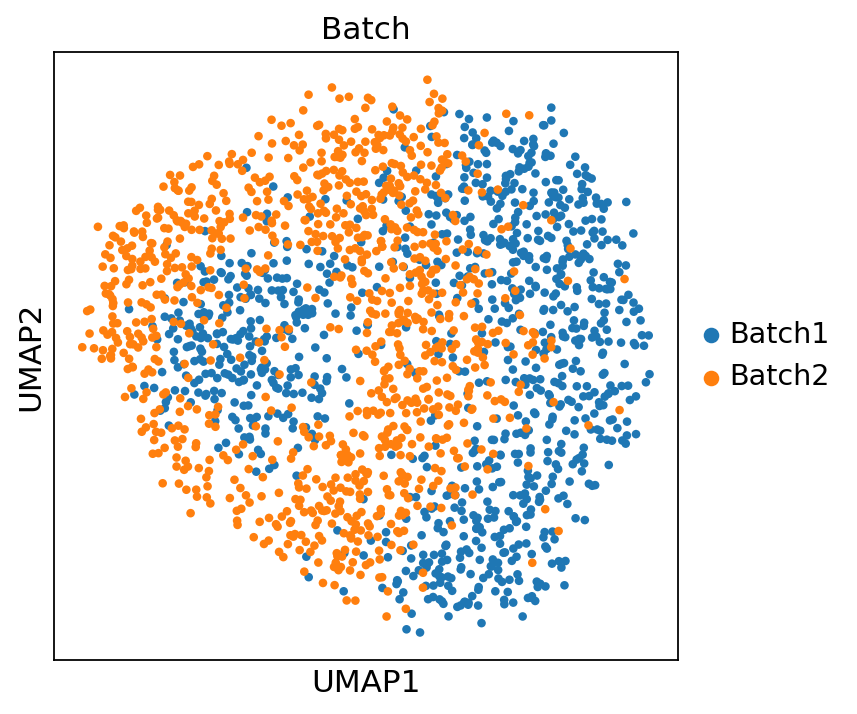

In [145]:
sc.pl.umap(adata, color="Batch")

In [ ]:
import numpy as np

np.random.seed(1)
adata_reorder = adata[np.random.permutation(adata.shape[0]), :].copy()

In [247]:
scvi.settings.seed = 1  # sysvi performance depends on random seed, perhaps due to vamp prior initialization??
SysVI.setup_anndata(adata_reorder, batch_key="Batch")
model = SysVI(adata_reorder, prior="vamp", n_prior_components=8)
model.train(
    max_epochs=200,
    plan_kwargs={
        "kl_weight": 1.0,  # default is 1
        "z_distance_cycle_weight": 0,  # default is 2
        "lr": 1e-2,
    },
    check_val_every_n_epoch=1,
)
adata.obsm["scvi"] = model.get_latent_representation()

Seed set to 1


INFO     The model has been initialized                                         


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [248]:
adata_reorder.obsm["scvi"] = model.get_latent_representation()

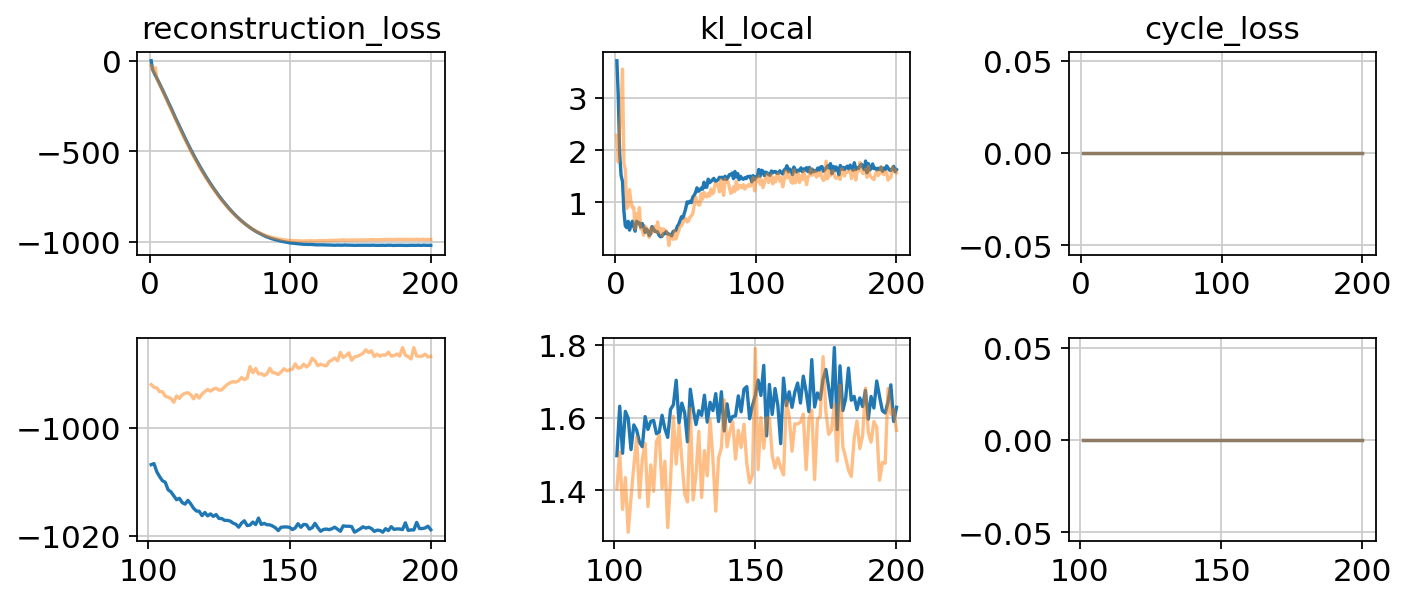

In [249]:
import matplotlib.pyplot as plt

epochs_detail_plot = 100

# Losses to plot
losses = [
    "reconstruction_loss_train",
    "kl_local_train",
    "cycle_loss_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    for l_values, c, alpha, dp in [
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, epochs_detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(
            l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha
        )

fig.tight_layout()

In [24]:
SCVI.setup_anndata(adata, batch_key="Batch")
model = SCVI(adata, gene_likelihood="nb", n_hidden=256, n_latent=30)
model.train(max_epochs=200)
adata.obsm["scvi"] = model.get_latent_representation()

/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [39]:
scvi.model.SCVI.setup_anndata(adata, batch_key="Batch")
model = scvi.model.SCVI(adata, gene_likelihood="nb")
model.train(max_epochs=200)
adata.obsm["scvi"] = model.get_latent_representation()

/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [250]:
sc.pp.neighbors(adata_reorder, use_rep="scvi", key_added="nei_scvi")
sc.tl.umap(adata_reorder, neighbors_key="nei_scvi", key_added="umap_scvi")

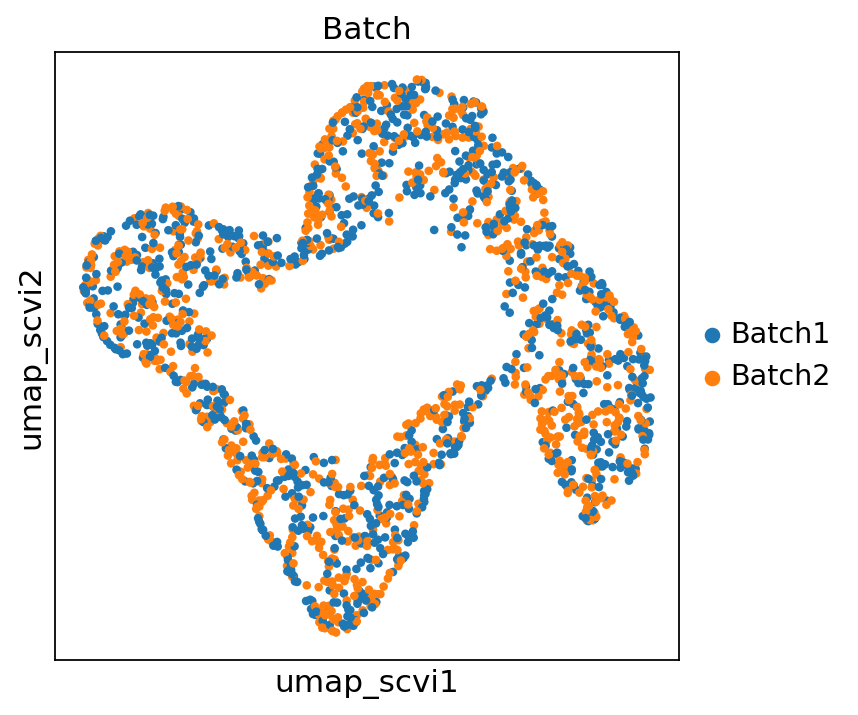

In [251]:
sc.pl.embedding(adata_reorder, basis="umap_scvi", color="Batch")

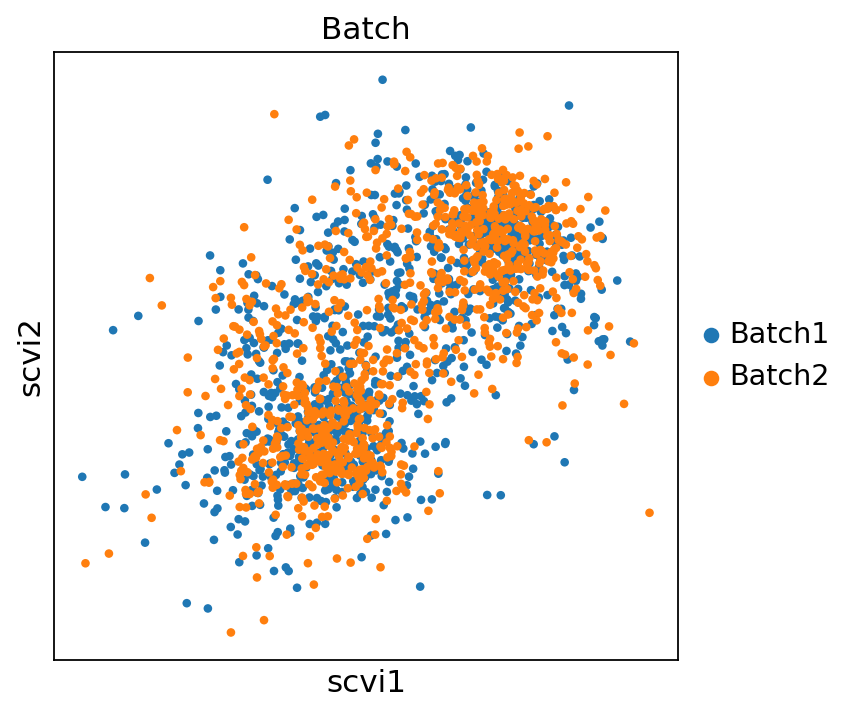

In [252]:
sc.pl.embedding(adata, basis="scvi", color="Batch", components=["1,2"])

In [136]:
adata_sub = adata[adata.obs["Batch"] == "Batch2"].copy()
sc.pp.neighbors(adata_sub)
sc.tl.diffmap(adata_sub)

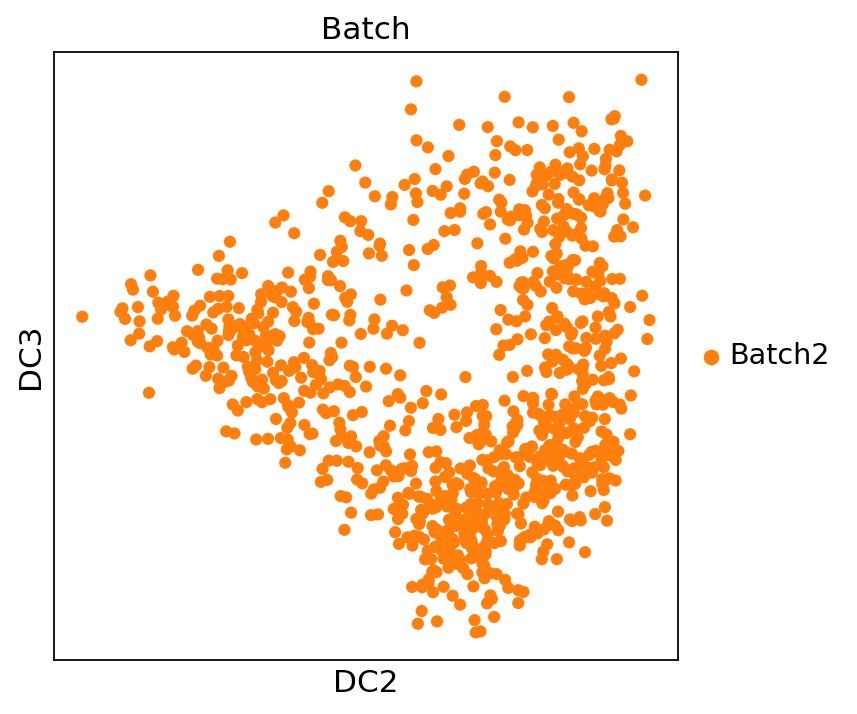

In [137]:
sc.pl.embedding(adata_sub, basis="diffmap", components=["2,3"], color="Batch")

In [253]:
sc.tl.diffmap(adata_reorder, neighbors_key="nei_scvi")

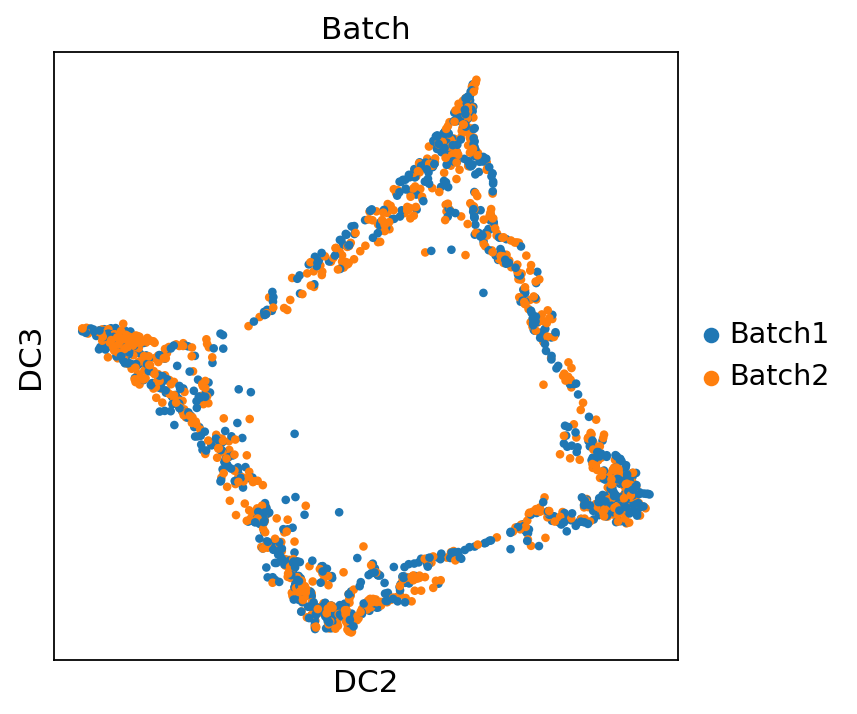

In [254]:
sc.pl.embedding(adata_reorder, basis="diffmap", components=["2,3"], color="Batch")